In [2]:
from transformers import TFViTForImageClassification, ViTFeatureExtractor
from utils import *

/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import ops
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config
    
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier(input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patch_size = 6
    dim = input_shape[0]
    num_patches = (dim // patch_size) ** 2
    projection_dim = 64
    num_heads = 16
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]  # Size of the transformer layers
    transformer_layers = 6
    mlp_head_units = [128, 64]  # Size of the dense layers of the final classifier

    # Patch creation
    patches = Patches(patch_size)(inputs)
    # Patch encoding
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.0)
    # Classify outputs.
    logits = layers.Dense(6)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='accuracy', patience=20)

2025-05-04 23:49:27.550894: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 23:49:30.928991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746398971.955573    1322 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746398972.238197    1322 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746398974.765678    1322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
count = {}
import os
import glob
for dir in os.listdir("train/"):
    count[dir] = len(glob.glob(os.path.join( "train/",dir, '*.jpg')))
    
total = sum(count.values())
class_weights = {cls: total / cnt for cls, cnt in count.items()}

from tensorflow.keras import backend as K
def weigthed_loss(class_weights):
    
    sorted_keys = sorted(class_weights.keys())
    weight_tensor = tf.constant([class_weights[k] for k in sorted_keys], dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(
            y_pred,
            K.epsilon(),
            1 - K.epsilon()
        )
        y_true_class = tf.argmax(y_true, axis=-1)
        ce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        sw = tf.gather(weight_tensor, y_true_class)
        return tf.reduce_mean(sw * ce)
    
    return loss

weigthed_loss_func = weigthed_loss(class_weights)

I0000 00:00:1746399082.699085    1322 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
IMG_SIZE = (256, 256, 3)
from utils import MModel
vit1 = MModel("vit1")
vit1.set_model(create_vit_classifier(input_shape=IMG_SIZE))
vit1.summary()

/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, 1764, 108) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 1764, 64)  │    119,872 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1764, 64)  │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1764, 64)  │    265,280 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1764, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1764, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1764, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1764, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1764, 64)  │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1764, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1764, 64)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1764, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1764, 64)  │    265,280 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1764, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1764, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1764, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1764, 128) │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1764, 64)  │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,272,134 (62.07 MB)

 Trainable params: 16,272,134 (62.07 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
vit1.compile(
    optimizer="adam",
    loss=weigthed_loss_func,
    metrics=["accuracy"]
)
hist_vit1 = vit1.fit(epochs=300, verbose=1, callbacks=[early_stopping])

(256, 256)
Found 2274 images belonging to 6 classes.
Found 253 images belonging to 6 classes.


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300


I0000 00:00:1746399122.284670    2772 service.cc:152] XLA service 0x7f89c8018630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746399122.284698    2772 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-05-04 23:52:02.773628: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746399124.173194    2772 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-04 23:52:06.409223: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 100 bytes spill stores, 100 bytes spill loads

2025-05-04 23:52:06.427774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/root/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/root/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/root/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3365, in run_cell_async

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3610, in run_ast_nodes

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3670, in run_code

  File "/tmp/ipykernel_1322/1871116276.py", line 6, in <module>

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/utils.py", line 96, in fit

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/utils.py", line 74, in _fit

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 64759228128 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_23956]

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━

2025-05-04 23:43:47.867161: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_56', 208 bytes spill stores, 580 bytes spill loads

2025-05-04 23:43:47.940100: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_56_0', 300 bytes spill stores, 300 bytes spill loads

2025-05-04 23:43:48.029176: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_56', 604 bytes spill stores, 604 bytes spill loads

2025-05-04 23:43:48.039214: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_56', 352 bytes spill stores, 352 bytes spill loads

2025-05-04 23:43:48.068983: I external

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/kkiko/Desktop/CAA/aa/CAA_P1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

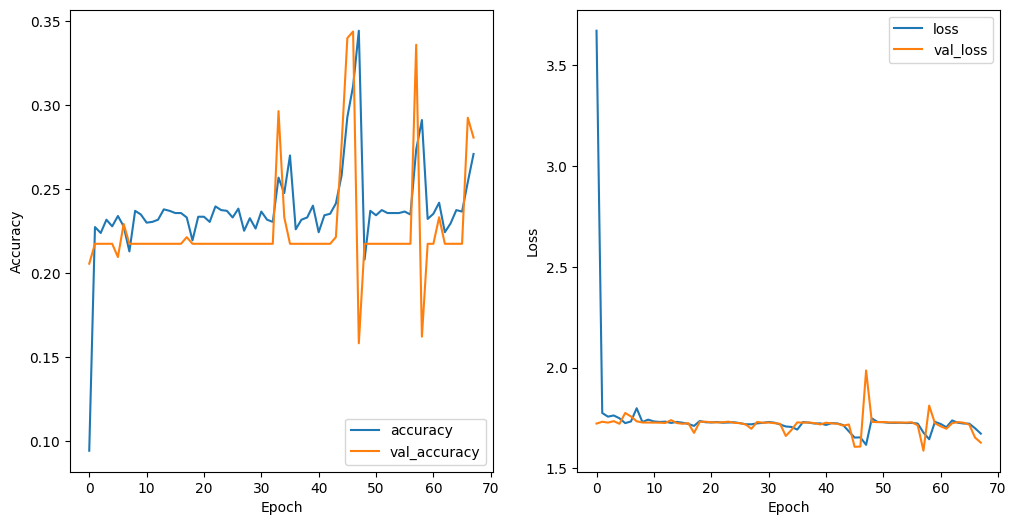

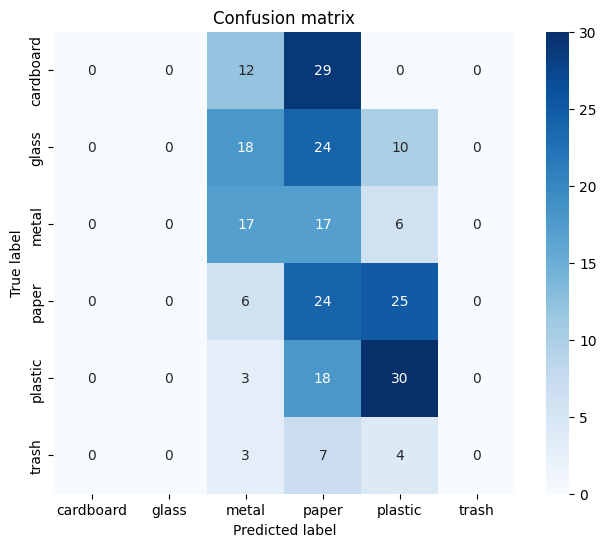

In [ ]:
vit1.evaluate()